# Multiple Imputation with Chained Equations
Author: Charles Guan

Demonstration of Multiple Imputation with Chained Equations (MICE) using a toy dataset (Iris) and scikit-learn.


In [1]:
import seaborn as sns
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Plot formatting
sns.set(style='ticks')

In [2]:
# Parameters
ratio_missing_data = 0.2
# Rule of thumb: one imputation per percent of incomplete data
num_imputations = round(ratio_missing_data * 100)

# Seed random state for reproducibility
# Remove hard-coded seed value for true pseudo-randomness
rng = np.random.default_rng(seed=73)

In [3]:
# Checks on parameters
assert 0 <= ratio_missing_data < 1, 'Invalid missing data ratio'

## Initialize sample dataset

In [4]:
# Load sample data
df = sns.load_dataset('iris')
df.index.name = 'observation'
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
observation,,,,,
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


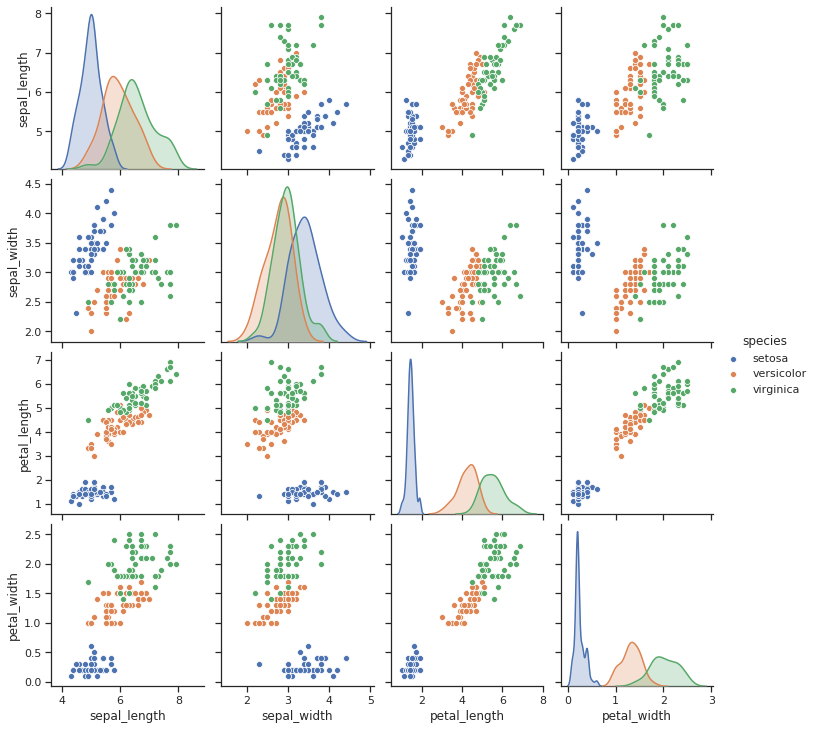

In [5]:
# Quick visualization of data
sns.pairplot(df, hue='species')

In [6]:
# Randomly replace some of the numeric values with NaNs
numeric_df = df.select_dtypes(include=np.number)
nonnumeric_df = df.select_dtypes(exclude=np.number)
missing_df = numeric_df.mask(rng.random(size=numeric_df.shape) < ratio_missing_data)

print('Number of rows:', len(missing_df))
print('Number of non-NaN values in each column:')
print(missing_df.count())

Number of rows: 150
Number of non-NaN values in each column:
sepal_length    121
sepal_width     122
petal_length    122
petal_width     117
dtype: int64


## Multiple Imputation with Chained Equations with scikit-learn

In [7]:
# Run multivariate imputations multiple times
# Accumulate results from each imputation
pred_df_list = []
for iter in range(num_imputations):
    # Add some random-ness to each iteration of the imputer
    random_state = rng.integers(np.iinfo(np.int32).max)
    imp = IterativeImputer(sample_posterior=True,
                           random_state=random_state)
    
    # Predict the missing data
    pred = imp.fit_transform(missing_df)
    pred_df = pd.DataFrame(pred,
                           columns=missing_df.columns,
                           index=missing_df.index)
    pred_df_list.append(pred_df)
    
# Merge results into a single dataframe
pred_all_df = pd.concat(pred_df_list,
                        keys=range(len(pred_df_list)),
                        names=['imputation'])
pred_all_df

sepal_length  sepal_width  petal_length  petal_width
imputation observation                                                      
0          0                5.100000     3.500000      1.400000     0.200000
           1                4.900000     3.492337      1.400000    -0.401134
           2                4.700000     3.200000      1.775936     0.566299
           3                4.600000     3.100000      2.549560     0.564816
           4                5.000000     3.600000      1.400000     0.316873
...                              ...          ...           ...          ...
19         145              6.700000     3.000000      5.021617     2.300000
           146              6.300000     2.500000      5.000000     1.647542
           147              5.860441     3.000000      5.200000     1.731575
           148              6.200000     3.050548      5.400000     2.300000
           149              5.900000     2.427669      5.726988     1.800000

[3000 rows x 4 columns]

## Normally, we should use Rubin's rules to pool results
For now, this is left out for simplicity. Instead we visualize the mean of the imputed values.

In [8]:
pred_mean_df = pred_all_df.mean(level='observation')
pred_mean_df.head()

,sepal_length,sepal_width,petal_length,petal_width
observation,,,,
0,5.1,3.500000,1.400000,0.200000
1,4.9,3.551319,1.400000,0.224889
2,4.7,3.200000,1.485843,0.231149
3,4.6,3.100000,1.695280,0.393201
4,5.0,3.600000,1.400000,0.263226


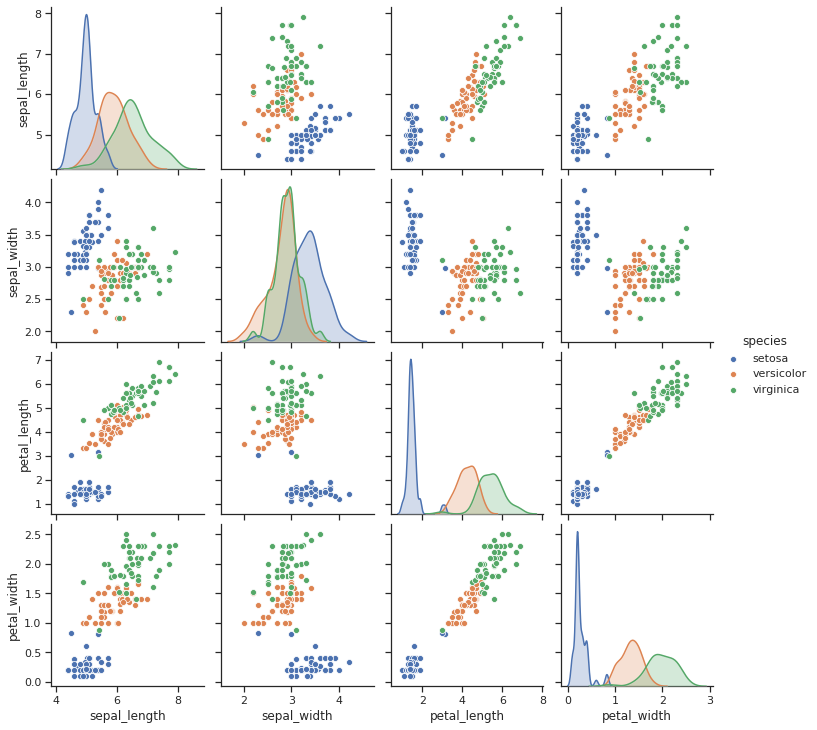

In [9]:
# Quick visualization of data, colored by species
pred_mean_df['species'] = df.species
sns.pairplot(pred_mean_df, hue='species')

Distribution of imputed data looks similar to original data distribution. However, not all values were predicted perfectly.

#### Show versions for documentation

In [10]:
print(np.__version__)

1.17.0


In [11]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.6.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.15.0-101-generic
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.0.3
numpy            : 1.17.0
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 20.0.2
setuptools       : 40.6.3
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.13.0
pandas_datareader: None
bs4              : 4.9.0
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3.1.3
numexpr      